# Evaluation: Compare Results Across All Four Models

This notebook loads saved results from **SVM**, **RNN**, **LSTM**, and **GRU** and produces comparison tables and figures for the report.

**Data source:** `outputs/tables/results_<model>_<embedding>.json`  
- SVM: `results_svm_tfidf.json`, `results_svm_skipgram.json`, `results_svm_cbow.json`  
- RNN: `results_rnn_tfidf.json`, `results_rnn_skipgram.json`, `results_rnn_cbow.json`  
- LSTM: `results_lstm_tf-idf.json`, `results_lstm_skipgram.json`, `results_lstm_cbow.json`, `results_lstm_glove.json`  
- GRU: `results_gru_tfidf.json`, `results_gru_skipgram.json`, `results_gru_cbow.json`  

If a model's results are missing, add the corresponding JSON files from that model's notebook. Run from **project root** so paths resolve.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Path to results (relative to project root)
TABLES_DIR = 'outputs/tables'
if not os.path.isdir(TABLES_DIR):
    TABLES_DIR = '../outputs/tables'
assert os.path.isdir(TABLES_DIR), f"Expected {TABLES_DIR} to exist. Run from project root."
print(f"Using results from: {os.path.abspath(TABLES_DIR)}")

Using results from: c:\Users\awini\MLT1_text-classification\outputs\tables


## 1. Load all result JSONs

In [2]:
rows = []
for f in sorted(os.listdir(TABLES_DIR)):
    if not f.endswith('.json'):
        continue
    path = os.path.join(TABLES_DIR, f)
    with open(path, 'r') as fp:
        d = json.load(fp)
    # Normalize embedding name (e.g. Skipgram -> Skip-gram)
    emb = d.get('embedding', '')
    if emb == 'Skipgram':
        emb = 'Skip-gram'
    rows.append({
        'model': d.get('model', ''),
        'embedding': emb,
        'accuracy': d.get('accuracy'),
        'precision_macro': d.get('precision_macro'),
        'recall_macro': d.get('recall_macro'),
        'f1_macro': d.get('f1_macro'),
        'train_time_sec': d.get('train_time_sec'),
    })

df = pd.DataFrame(rows)
EXPECTED_MODELS = ['SVM', 'RNN', 'LSTM', 'GRU']
models_found = df['model'].unique().tolist()
models_missing = [m for m in EXPECTED_MODELS if m not in models_found]
print(f"Loaded {len(df)} result rows. Models found: {models_found}")
if models_missing:
    print(f"Missing (add JSONs to outputs/tables): {models_missing}")
df

Loaded 10 result rows.


,model,embedding,accuracy,precision_macro,recall_macro,f1_macro,train_time_sec
0,GRU,CBOW,0.933881,NaN,NaN,NaN,NaN
1,GRU,Skip-gram,0.946765,NaN,NaN,NaN,NaN
2,GRU,TF-IDF,0.974090,NaN,NaN,NaN,NaN
3,LSTM,CBOW,0.950446,0.954273,0.948465,0.951043,124.54
4,LSTM,GloVe,0.954269,0.957524,0.952684,0.954751,354.72
5,LSTM,Skip-gram,0.956676,0.960878,0.955986,0.957568,118.83
6,LSTM,TF-IDF,0.970976,0.971800,0.972171,0.971963,114.74
7,SVM,CBOW,0.423469,0.399451,0.423993,0.388741,NaN
8,SVM,Skip-gram,0.443878,0.417582,0.448352,0.416353,NaN
9,SVM,TF-IDF,0.520408,0.548823,0.543040,0.537041,NaN


## 2. Comparison table (all models × embeddings)

In [3]:
# Pivot: rows = model, columns = embedding, values = accuracy (order: SVM, RNN, LSTM, GRU)
model_order = [m for m in EXPECTED_MODELS if m in df['model'].values]
acc_pivot = df.pivot_table(index='model', columns='embedding', values='accuracy').reindex(index=model_order)
print("Accuracy by Model and Embedding")
print(acc_pivot.round(4).to_string())
print()

if df['f1_macro'].notna().any():
    f1_pivot = df.pivot_table(index='model', columns='embedding', values='f1_macro').reindex(index=model_order)
    print("F1 (macro) by Model and Embedding")
    print(f1_pivot.round(4).to_string())

Accuracy by Model and Embedding
embedding    CBOW   GloVe  Skip-gram  TF-IDF
model                                       
GRU        0.9339     NaN     0.9468  0.9741
LSTM       0.9504  0.9543     0.9567  0.9710
SVM        0.4235     NaN     0.4439  0.5204

F1 (macro) by Model and Embedding
embedding    CBOW   GloVe  Skip-gram  TF-IDF
model                                       
LSTM       0.9510  0.9548     0.9576   0.972
SVM        0.3887     NaN     0.4164   0.537


In [ ]:
# Use canonical order (SVM, RNN, LSTM, GRU) for all plots
model_order = [m for m in EXPECTED_MODELS if m in df['model'].values]
embeddings = df['embedding'].unique().tolist()

## 3. Bar charts: Accuracy by embedding (grouped by model)

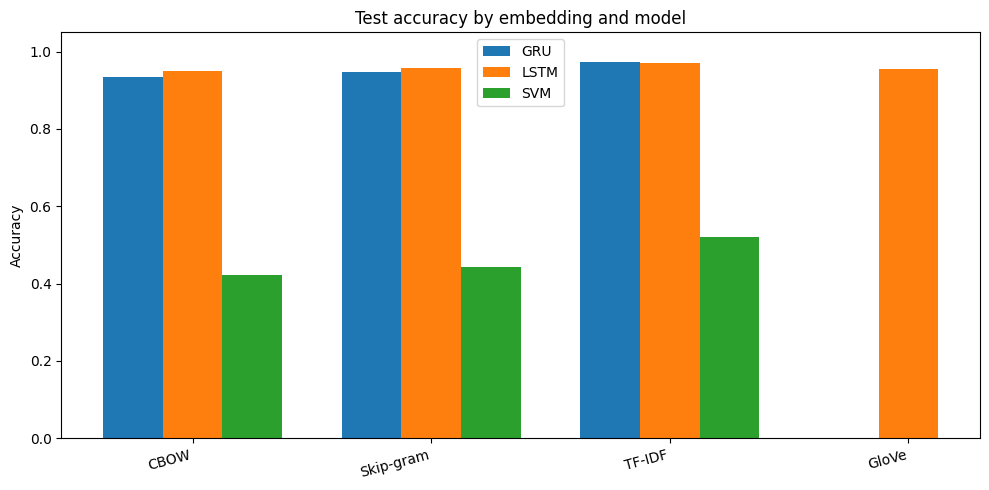

In [4]:
models = model_order
embeddings = df['embedding'].unique().tolist()
x = np.arange(len(embeddings))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 5))
for i, mod in enumerate(models):
    vals = [df[(df['model'] == mod) & (df['embedding'] == e)]['accuracy'].values[0] if len(df[(df['model'] == mod) & (df['embedding'] == e)]) else np.nan for e in embeddings]
    ax.bar(x + i * width, vals, width, label=mod)
ax.set_xticks(x + width)
ax.set_xticklabels(embeddings, rotation=15, ha='right')
ax.set_ylabel('Accuracy')
ax.set_title('Test accuracy by embedding and model')
ax.legend()
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

## 4. Bar charts: Accuracy by model (grouped by embedding)

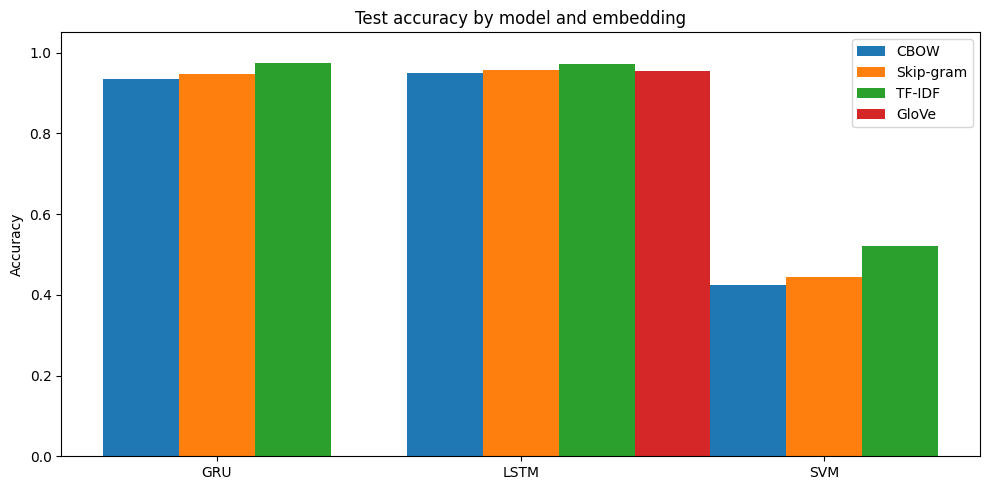

In [5]:
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 5))
for i, emb in enumerate(embeddings):
    vals = [df[(df['model'] == m) & (df['embedding'] == emb)]['accuracy'].values[0] if len(df[(df['model'] == m) & (df['embedding'] == emb)]) else np.nan for m in models]
    ax.bar(x + i * width, vals, width, label=emb)
ax.set_xticks(x + width)
ax.set_xticklabels(models)
ax.set_ylabel('Accuracy')
ax.set_title('Test accuracy by model and embedding')
ax.legend()
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

## 5. Heatmap: Model × Embedding (accuracy)

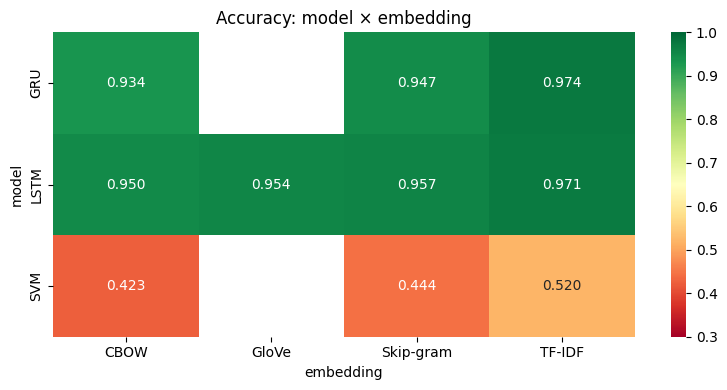

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
acc_pivot = df.pivot_table(index='model', columns='embedding', values='accuracy')
sns.heatmap(acc_pivot, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0.3, vmax=1.0, ax=ax)
ax.set_title('Accuracy: model × embedding')
plt.tight_layout()
plt.show()

## 6. Summary table (for report)

In [7]:
summary = df.pivot_table(index=['model', 'embedding'], values=['accuracy', 'f1_macro'], aggfunc='first').reset_index()
summary = summary.round(4)
print("Full comparison (copy to report):")
display(summary)

Full comparison (copy to report):


,model,embedding,accuracy,f1_macro
0,GRU,CBOW,0.9339,NaN
1,GRU,Skip-gram,0.9468,NaN
2,GRU,TF-IDF,0.9741,NaN
3,LSTM,CBOW,0.9504,0.9510
4,LSTM,GloVe,0.9543,0.9548
5,LSTM,Skip-gram,0.9567,0.9576
6,LSTM,TF-IDF,0.9710,0.9720
7,SVM,CBOW,0.4235,0.3887
8,SVM,Skip-gram,0.4439,0.4164
9,SVM,TF-IDF,0.5204,0.5370
